# This script prepares for the coming simulation study. 

### Stage I: interpolate data for the area inside the operational area using SINMOD. 

In [36]:
from src.WGS import WGS
import os
import netCDF4
import numpy as np
import pandas as pd
from shapely.geometry import Polygon, Point

filepath = "/Users/yaolin/Library/CloudStorage/OneDrive-NTNU/MASCOT_PhD/Data/Nidelva/SINMOD_DATA/samples/samples_2022.05.11.nc"
path_border = "src/csv/polygon_border.csv"
path_obstacle = "src/csv/polygon_obstacle.csv"

sinmod = netCDF4.Dataset(filepath)
plg_border = pd.read_csv(path_border).to_numpy()
plg_obstacle = pd.read_csv(path_obstacle).to_numpy()
plg_b_sh = Polygon(plg_border)
plg_o_sh = Polygon(plg_obstacle)

timestamp = sinmod['time']
lat = np.array(sinmod['gridLats'])
lon = np.array(sinmod['gridLons'])
depth = np.array(sinmod['depth'])
salinity = np.array(sinmod['salinity'])

sal = np.nanmean(salinity[:, 0, :, :], axis=0)
lat = lat.flatten()
lon = lon.flatten()
sal = sal.flatten()

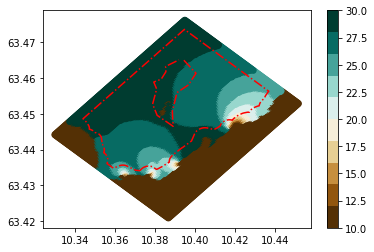

In [25]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
plt.scatter(lon, lat, c=sal, cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)
plt.plot(plg_border[:, 1], plg_border[:, 0], 'r-.')
plt.plot(plg_obstacle[:, 1], plg_obstacle[:, 0], 'r-.')
plt.colorbar()

In [31]:
def border_contains(loc: np.ndarray) -> bool:
    """ Test if point is within the border polygon """
    lat, lon = loc
    point = Point(lat, lon)
    return plg_b_sh.contains(point)

def obstacle_contains(loc: np.ndarray) -> bool: 
    lat, lon = loc
    point = Point(lat, lon)
    return plg_o_sh.contains(point)

def get_legal_indices(lat, lon) -> np.ndarray: 
    ind = []
    for i in range(len(lat)):
        loc = np.array([lat[i], lon[i]])
        if border_contains(loc) and not obstacle_contains(loc):
            ind.append(True)
        else: 
            ind.append(False)
    return ind

In [32]:
ind_legal = get_legal_indices(lat, lon)

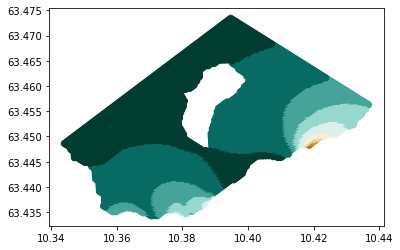

In [34]:
plt.scatter(lon[ind_legal], lat[ind_legal], c=sal[ind_legal], cmap=get_cmap("BrBG", 10), vmin=10, vmax=30)

In [38]:
lat_l = lat[ind_legal]
lon_l = lon[ind_legal]
sal_l = sal[ind_legal]
x, y = WGS.latlon2xy(lat_l, lon_l)
dataset = np.stack((x, y, sal_l), axis=1)
df = pd.DataFrame(dataset, columns=['x', 'y', 'salinity'])
df.to_csv("prior/sinmod.csv", index=False)
